**Kernel description:**

This kernel demonstrates the data analysis over a time series Dataset over regions of the USA. This kernel was written as a project evaluation for my intership interview in [SpadeEMS](https://spadeems.com). Go check them out!

First of all, I'd like to point out that dataset used in this notebook is an older version, newer verion is availible [here](https://www.kaggle.com/timmate/avocado-prices-2020).
<br><br>Secondly, units for different types of avacados are still unclear.. you can checkout this [discussion](https://www.kaggle.com/neuromusic/avocado-prices/discussion/64131) for more.
<br><br>At Last, the feature **"region"** has some places which are already the subsets for other region, these rows may cause some unexpected efffects over ANN's, so make sure to normalize all features.

ROOM TO IMPROVE:
* Plot things with population density and housing price's datasets to get better visualizations.
* Build models to predict the average price over the coming years.
* Use random forest, ANN's, Facebook's Prophet API.

# Table of contents
* [Importing Necessary Libraries]()
* [Get the Data]()
* [Describe what's the data about]()
* [Interpretation]()
* [Deep Dive into the visualizations]()
* [How well do Avacados sell over different regions]()
* [What Millenials actually want]()
* [Data Prepration]()
* [Colinearity]()

# Let's Begin

**Millenials LOVE Avocado Toast, can we find a city for them where they can have their avocado toast and buy a home?<br>
Let's find out.**

## What's our Data(Input)

In [1]:
# Uncomment if in Kaggle.

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip --quiet install fastai pandas-summary

In [4]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import rcParams

from fastai.imports import *

from pandas_summary import DataFrameSummary
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from IPython.display import display

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Avacado Prices

## Data

In [5]:
df_raw = pd.read_csv('./data/avocado.csv', parse_dates=["Date"])

df_raw.drop(['Unnamed: 0'], axis = 1, inplace=True) # Removing the un-known column

### Have a peek

In [6]:
df_raw.sort_values(by=['Date'], inplace=True, ascending=True)
df_raw.reset_index(drop=True, inplace=True)
df_raw.head() # Look at the Data

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
1,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
2,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
3,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
4,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


## Is Everything there? What does it mean

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


In [8]:
df_raw.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Date,18249,169,2015-05-24 00:00:00,108,2015-01-04,2018-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AveragePrice,18249,NaN,NaN,NaN,NaT,NaT,1.40598,0.402677,0.44,1.1,1.37,1.66,3.25
Total Volume,18249,NaN,NaN,NaN,NaT,NaT,850644,3.45355e+06,84.56,10838.6,107377,432962,6.25056e+07
4046,18249,NaN,NaN,NaN,NaT,NaT,293008,1.26499e+06,0,854.07,8645.3,111020,2.27436e+07
4225,18249,NaN,NaN,NaN,NaT,NaT,295155,1.20412e+06,0,3008.78,29061,150207,2.04706e+07
4770,18249,NaN,NaN,NaN,NaT,NaT,22839.7,107464,0,0,184.99,6243.42,2.54644e+06
Total Bags,18249,NaN,NaN,NaN,NaT,NaT,239639,986242,0,5088.64,39743.8,110783,1.93731e+07
Small Bags,18249,NaN,NaN,NaN,NaT,NaT,182195,746179,0,2849.42,26362.8,83337.7,1.33846e+07
Large Bags,18249,NaN,NaN,NaN,NaT,NaT,54338.1,243966,0,127.47,2647.71,22029.2,5.7191e+06
XLarge Bags,18249,NaN,NaN,NaN,NaT,NaT,3106.43,17692.9,0,0,0,132.5,551694


**So nothing missing, Great!!**

## What's the Interpretation

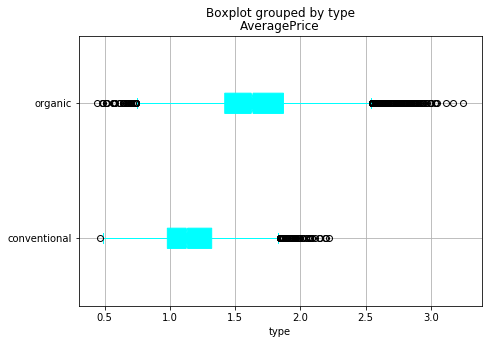

In [9]:
df_raw.boxplot(notch=True, column='AveragePrice', by='type', figsize=(7, 5), 
               vert=False, color='cyan', patch_artist=True);

**Looks like Organic Avacados are more expensive than conventional Avacados (on average)... As it sbould be!!**<br>
Production costs for organic foods are typically higher because of greater labour inputs per unit.

**Lets Look at another way of classifying this plot**

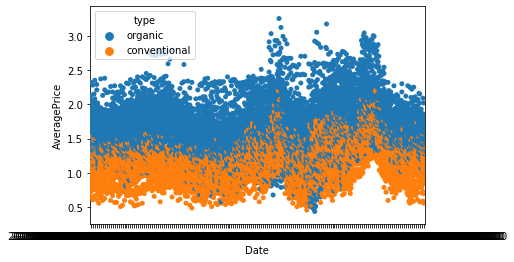

In [10]:
sns.swarmplot('Date','AveragePrice', data=df_raw, hue='type'); # this will take a minute to run

**AHH, Now that clears it all, nice let's move forward**

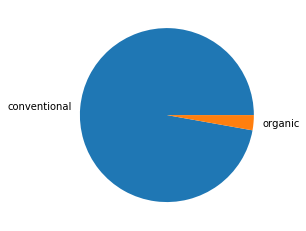

In [11]:
df_tmp = df_raw.groupby('type').sum()
plt.pie(df_tmp['Total Volume'], data = df_tmp, labels = ['conventional','organic'])
plt.show()

**Looks like very few people buy organic avacados, conventional are much more popular. I wonder...**

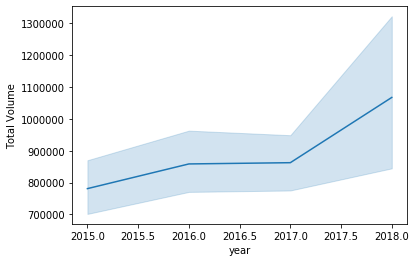

In [12]:
sns.lineplot(x = 'year', y = 'Total Volume', data = df_raw, palette= 'Blues');

**So avacado's market price keeps on increasing every year, Let's find out WHY...**

###### We are getting a monotonicity in graph for Voulme Sold per year... That was expected but what about that almost constant period
*Quoted from CNBC News Nov 4, 2016* [link](https://www.cnbc.com/2016/11/04/avocado-prices-starting-to-come-down-as-more-supplies-arrive.html)<br>
Grabbed a quote from the article
--"Relief is in sight for guacamole lovers as avocado supplies have started increasing and prices are expected to come down over the next several weeks."

**Lets go in-depth and try to decompose this plot into several other plots so that it can easily understood**

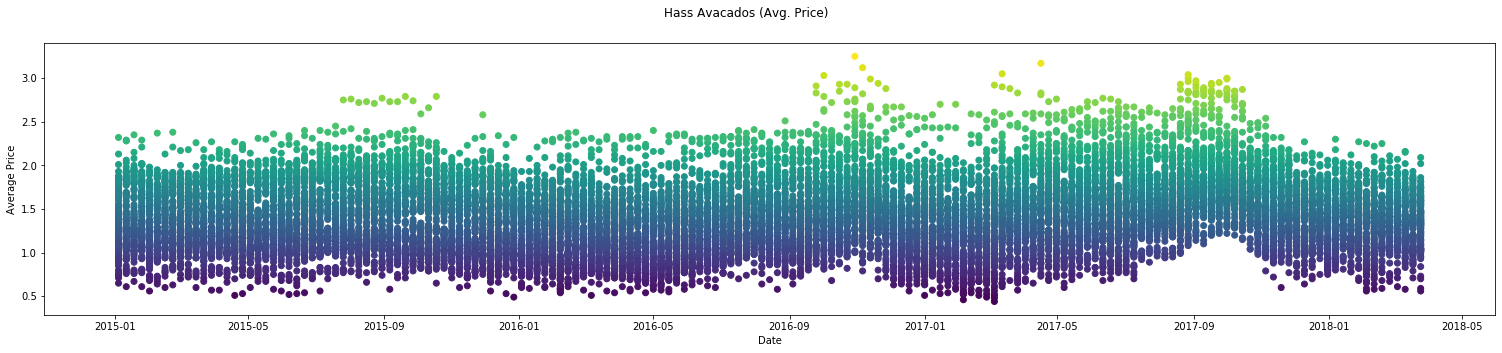

In [13]:
fig = plt.figure(figsize = (26, 5))
ax = fig.add_subplot(111)
plt.scatter(df_raw['Date'], df_raw['AveragePrice'], c=df_raw['AveragePrice']);
fig.suptitle('Hass Avacados (Avg. Price)');
ax.set_xlabel('Date');
ax.set_ylabel('Average Price');

> Quite a few bumps, hmmmm lets look at each category differently

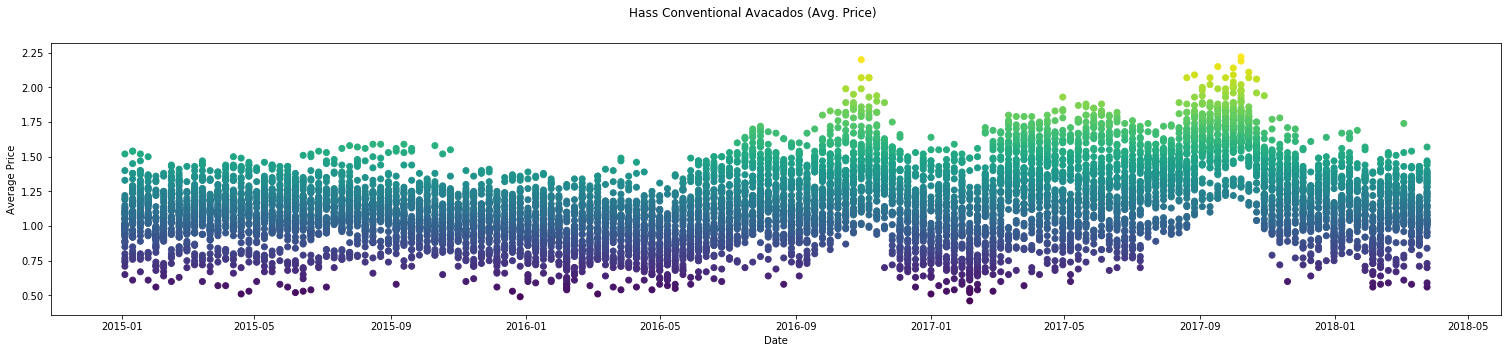

In [14]:
fig = plt.figure(figsize = (26, 5))
ax = fig.add_subplot(111)
plt.scatter(df_raw[df_raw['type']=='conventional']['Date'], 
            df_raw[df_raw['type']=='conventional']['AveragePrice'], 
            c=df_raw[df_raw['type']=='conventional']['AveragePrice']);
fig.suptitle('Hass Conventional Avacados (Avg. Price)');
ax.set_xlabel('Date');
ax.set_ylabel('Average Price');

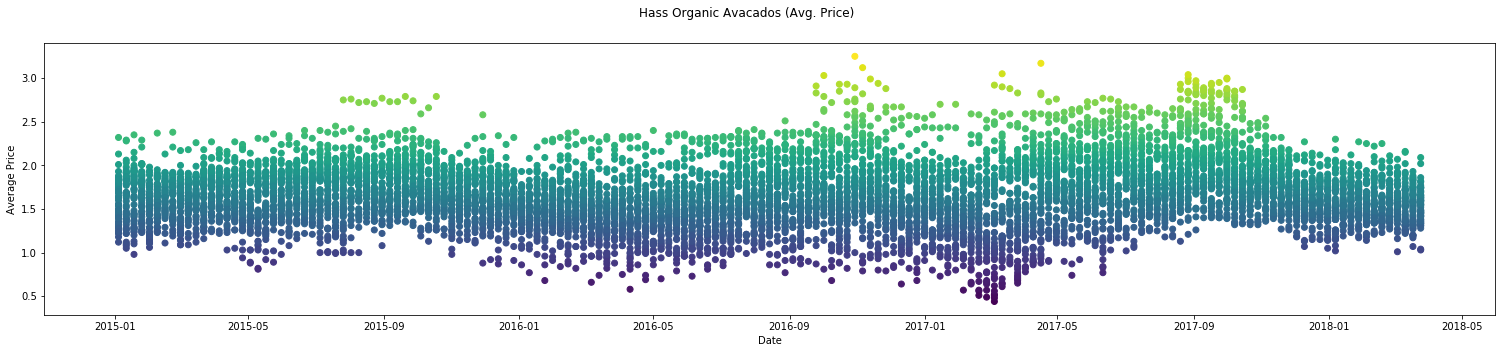

In [15]:
fig = plt.figure(figsize = (26, 5))
ax = fig.add_subplot(111)
plt.scatter(df_raw[df_raw['type']=='organic']['Date'], 
            df_raw[df_raw['type']=='organic']['AveragePrice'], 
            c=df_raw[df_raw['type']=='organic']['AveragePrice']);
fig.suptitle('Hass Organic Avacados (Avg. Price)');
ax.set_xlabel('Date');
ax.set_ylabel('Average Price');

### What can be concurred from plots?
> Well, some Googling led me to the fact there was a shoratge of avacados in late 2016 because of **The great avocado shortage of 2016** which was due to labor strikes in Mexico, California's protracted drought, an invidious beetle that destroys avocado groves, and a changing climate that is less hospitable to the crop. That is why we see a rise in price during the end of 2016

> We see the same kind if rise in mid 2017. Volatile prices in 2017 can be blamed on a dismal California harvest, which started in February.

References / Citations
[1](https://www.ocregister.com/2017/08/16/avocado-shortage-a-perfect-storm-of-problems-is-causing-a-surge-in-prices/)
[2](https://www.freshfruitportal.com/news/2019/07/16/avocados-in-charts-why-falling-prices-could-settle-below-2018s-levels/)
[3](https://www.bbc.com/news/business-39768480)

## Which City(s) sells the cheapest or the most expensive Avacados 

### Let's look at most expensive first

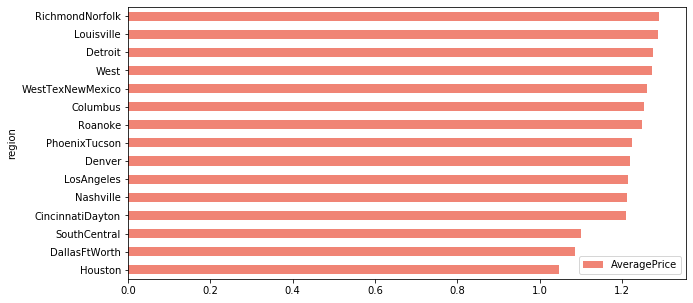

In [16]:
df_test = df_raw.groupby(["region"]).mean()
df_test = pd.DataFrame(df_test['AveragePrice'].sort_values())[:15]
exp_ava_city = df_test.iloc[-1]
cheapest_ava_city = df_test.iloc[0]
df_test.plot(y='AveragePrice', kind='barh', figsize=(10, 5), color=(0.9, 0.2, 0.1, 0.6));

### Coming to the cheapest

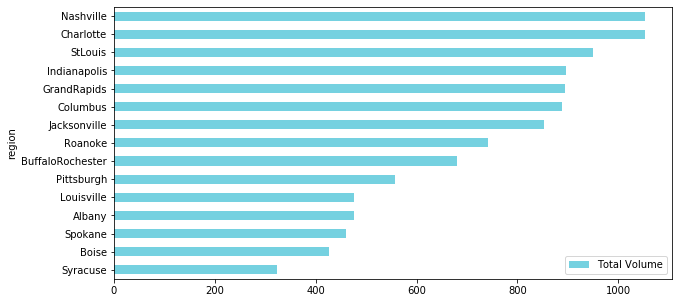

In [17]:
df_test = df_raw.groupby(["region"]).mean()
df_test['Total Volume'] = df_test['Total Volume'] / 100
df_test = pd.DataFrame(df_test['Total Volume'].sort_values())[:15]
df_test.plot(y = 'Total Volume', kind = 'barh', figsize = (10, 5), color=(0.1, 0.7, 0.8, 0.6));

In [18]:
cheapest_ava_city, exp_ava_city

(AveragePrice    1.047929
 Name: Houston, dtype: float64,
 AveragePrice    1.291331
 Name: RichmondNorfolk, dtype: float64)

**Avacados** are cheapest in **Houston** and most expensive in **RichmondNorfolk**.<br>
<br>NOTE : THESE ANALYTICS MAY VARY IF POPULATION DENSITY IS ALSO TAKEN INTO ACCOUNT.
<BR>IT SHOULD BE CONSIDERED, BUT DUE TO TIME CONTRAINTS I'M GOING WITH THIS INTERPRETATION.

## Finally, What do Millenials actually want??

### Let's look at Region wise different Avacado Type Demand 

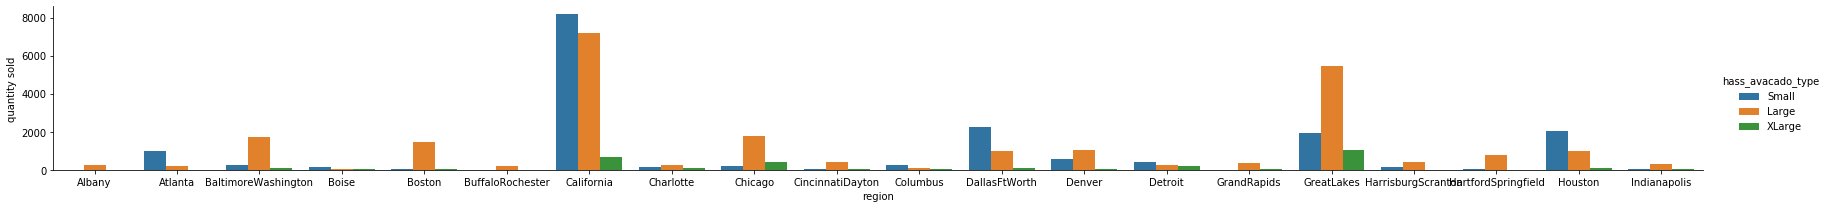

In [19]:
df_cat = df_raw.groupby(["region"], as_index=False).sum()
df_cat.rename(columns={'4046':'Small', '4225':'Large', '4770':'XLarge'}, inplace=True)
df_test = df_cat[['region', 'Small','Large', 'XLarge']][:20]

df_test = pd.melt(df_test, id_vars='region', var_name="hass_avacado_type", value_name="quantity sold")
df_test['quantity sold'] = df_test['quantity sold'] / df_test['quantity sold'].min(); df_test
sns.catplot(x='region', y='quantity sold', hue='hass_avacado_type', data=df_test, kind='bar',  height=3, aspect=8);

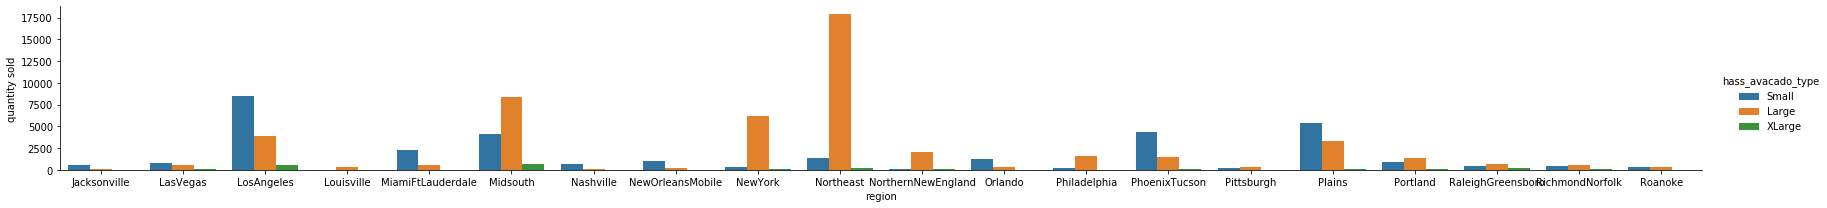

In [20]:
df_test = df_cat[['region', 'Small','Large', 'XLarge']][20:40]

df_test = pd.melt(df_test, id_vars='region', var_name="hass_avacado_type", value_name="quantity sold")
df_test['quantity sold'] = df_test['quantity sold'] / df_test['quantity sold'].min(); df_test
sns.catplot(x='region', y='quantity sold', hue='hass_avacado_type', data=df_test, kind='bar',  height=3, aspect=8);

#### Now that is a good example of how the same GENERATIONS LIKELINESS CAN VARY over such SMALL DISTANCES

The above plots shows the **LIKENESS FOR DIFFERENT TYPES OF AVACADOS ACROSS DIFFERENT REGIONS** 
<br>**Conclusion : On average people in US like to buy Large Avacados, also people are crazy about avacados**

I am only showing some of these plot but you can go ahead and plot all the plot using subplots and axes... This was a fun assigment but I had very little time to the analyze and implement it. 

> Happy Learning, Cheers !!

## DATA PREPRATION FOR FEEDING IT TO A MODEL

> This dataset contains a mix of continuous and categorical variables.
The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. Without expanding our date-time into these additional fields, we can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [21]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):  
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [22]:
add_datepart(df_raw, 'Date')

In [23]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

#### Feeling Deja-Vu... No?.. hmmm.. I'm amazed if you aren't

In [24]:
y = df_raw['AveragePrice']
df = df_raw.drop('AveragePrice', axis=1)

### IT's READY, Now you can chuck it into a forrest or a nueral network

# Colinearity

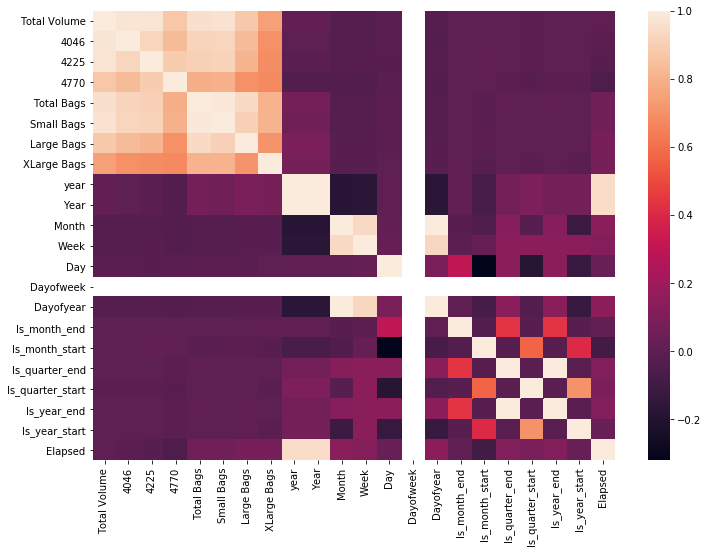

In [25]:
rcParams['figure.figsize'] = 11.7,8.27
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

# Hmmmmm... found some collinearities

**Like and share the kernel if you think it's nice... MORE STUFF COMING... CHEERIO**